<h1 style="text-align: center; font-weight: bold; color: white; text-decoration: underline; font-variant: small-caps;">Machine Learning based Typeface Recognition Tool</h1>
Last edited: 09/Dec/2024

---

# **0. Introduction**
Team members:
1. 2022A7PS0004U – Yusra Hakim
2. 2022A7PS0019U – Joseph Cijo
3. 2022A7PS0034U – Sreenikethan Iyer
4. 2022A7PS0036U – Mohammed Emaan

This is the Jupyter Notebook for the Foundations of Data Science (CS F320)
project. The basic premise of this project is to create a font recognition model
trained using the [dataset](#dataset-used) mentioned below.

## Dataset used
R. Lyman. "Character Font Images," UCI Machine Learning Repository, 2016. [Online]. Available: https://doi.org/10.24432/C5X61Q.

<!-- ## Libraries used -- TODO:
| Library                                                | Purpose          |
| ---                                                    | ---              |
| [NumPy](https://numpy.org/)                            |                  |
| [SciPy](https://scipy.org/)                            |                  |
| [pandas](https://pandas.pydata.org/)                   | Data Handling    |
| [PIL/Pillow](https://pillow.readthedocs.io/en/stable/) | Image Handling   |
| [scikit-learn](https://scikit-learn.org/stable/)       | Machine Learning |
| [TensorFlow](https://www.tensorflow.org/)              | Neural Networks  |
| [colorama](https://pypi.org/project/colorama/)(?)      |                  | -->

## How to set up environment:
Please see the [README.md](README.md) file.


---

# **1. Rough outline**
For training the model, the rough sequence of actions is as follows:
1. Load character image data into memory.
2. Create variations by shearing, scaling, stretching, adding noise, etc.
3. Train a CNN model on these inputs.

The model will accept two inputs, namely the character code and the image of the
character. It will output the font name.

In the actual end product, the character code detection can be trivially done
by asking the user itself for typing out the character in the image, or can be
automated with an OCR implementation.

In [ ]:
%pip install pillow

In [1]:
from PIL import Image
from glob import glob
from os.path import basename, isfile
from collections import defaultdict
import pickle
import ipywidgets


---

# **2. Data loading and preprocessing**


In [ ]:
# Use -I flag to ignore installed, if you want to forcefully reinstall.
%pip install numpy torch torchvision --index-url https://download.pytorch.org/whl/cu124

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.v2 as transforms
import numpy as np
from time import perf_counter


## OLD model

Some global constants, such as directory paths, shall be stored here for the
ease of changing them later on.

Here, data preprocessing involves parsing the CSV files and generating image
data from the given array of pixels, scaling them, etc.

We have authored a separate script called [`parse_csv.py`](DatasetUCI/parse_csv.py)
which contains methods to load a CSV file and read all characters into Python
objects. All the loaded data is then saved to the disk as one large file in
Python's own `pickle` format, which makes loading the dataset much more
efficient in the future.

In [ ]:
from DatasetUCI.parse_csv import *

# The folder where all the CSVs are stored.
PATH_CSVS         = "DatasetUCI/character+font+images/"
PATH_CHARS_PICKLE = "DatasetUCI/character+font+images.pickle"
PATH_MODELS       = "Models/"


In [ ]:
# OLD DATASET
count_chars: int
count_fonts: int
characters: dict[int, list[Character]]
pickle_loaded = False # Flag to inform whether pickle loading was successful

# Check if pickle file is already there.
if isfile(PATH_CHARS_PICKLE):
    try:
        with open(PATH_CHARS_PICKLE, "rb") as f:
            count_chars, count_fonts, characters = pickle.load(f)
        pickle_loaded = True
        print("Successfully loaded pickled data.")
    except Exception as e:
        print("Loading pickled data failed, reason:", e)

if not pickle_loaded:
    count_chars = 0
    count_fonts = 0
    characters = defaultdict(list)
    csv_files = glob(f"{PATH_CSVS}*.csv")
    print(f"Parsing {len(csv_files)} CSV files:")
    for i, filename in enumerate(csv_files):
        print(f"  Loading [{i+1}/{len(csv_files)}] {basename(filename)}... ",end="")
        chars = parse_csv(filename)
        count_fonts += 1
        for char in chars:
            characters[char['m_label']].append(char)
            count_chars += 1
        del chars
        print("done.")

    if input("Save pickled file? [Y/n] ").strip().lower()[:1] != "n":
        try:
            with open(PATH_CHARS_PICKLE, "wb") as f:
                pickle.dump((count_chars, count_fonts, characters), f)
            print("Successfully saved pickled data.")
        except Exception as e:
            print("Saving pickled data failed, reason:", e)

print("\nStatistics:")
print("  unique character codes:", len(characters))
print("  total character count :", count_chars)
print("  total font count      :", count_fonts)


### Dataset reduction

There are **832670** unique characters in this dataset, which includes
characters from all scripts such as Devanagiri, Arabic, Chinese, etc.

To start at a lower scale and to significantly reduce training time, let's
assume this tool is aimed at an English-speaking audience, hence we shall train
it only on a very specific subset of the characters. There can be two choices:
1. QWERTY-keyboard: 94 characters, **406044** unique character images, 51.24% reduction.
2. Alpha numeric (A-Z, a-z, 0-9): 62 characters, **331390** unique character images, 60.20% reduction.

Choose one by changing the `TO_USE` variable below.

Note that this will delete the other characters from the dataset. To restore all
the characters, just run the above code block to reload from the file again.

In [ ]:
QWERTY = "`1234567890-=qwertyuiop[]\\asdfghjkl;'zxcvbnm,./~!@#$%^&*()_+QWERTYUIOP{}|ASDFGHJKL:\"ZXCVBNM<>?"
ALNUM = "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm0123456789"

TO_USE = ALNUM

for key_to_remove in set(characters) - set(map(ord, TO_USE)):
    del characters[key_to_remove]

print("Total characters:", sum(map(len, characters.values())))


In [ ]:
class FontDataset(Dataset):
    # The below three consist of every single character, where each index in
    # each of the following fields correspond to one character entry.
    data: list # List of images (where each image is a numpy array)
    codes: list[int] # List of character codes (where each code is an int)
    labels: list[int] # List of labels (where each label is an int)

    # The transform sequence to be applied to an image:
    transform_image: transforms.Transform | None

    # The mapping used to represent a font name as a unique integer, "Font ID number" if you will.
    label_mapping: dict[str, int] # Font Name -> Font ID
    label_reverse_mapping: list[str] # Font ID -> Font name (basically just index the list normally)

    def __init__(self, characters: dict[int, list[Character]], transform_image: transforms.Transform | None=None):
        self.data = []
        labels_strs: list[str] = []
        self.codes = []
        self.transform_image = transform_image

        # Flatten the dictionary into a list of samples
        for codepoint, chars in characters.items(): #sorted(characters.items(), key=lambda entry: (-len(entry[1]), entry[0])):
            for char_obj in chars:
                # 1. Image of the current character
                image = np.frombuffer(bytes([255-x for x in char_obj["data"]]), dtype=np.uint8).reshape((char_obj["h"], char_obj["w"])) # i.e. 20×20

                # 2. Character code (Unicode codepoint) of the character
                char_code = codepoint # same as char_obj["m_label"]

                # 3. Font name of the character (i.e. "output")
                label = char_obj["font"] # Use font name as the label

                self.data.append(image)
                self.codes.append(char_code)
                labels_strs.append(label)

        # Basically denote every font name with a number, useful for classification
        self.label_reverse_mapping = list(set(labels_strs)) # TODO: SORT THIS IG?
        self.label_mapping = {label: i for i, label in enumerate(self.label_reverse_mapping)}
        self.labels = [self.label_mapping[label] for label in labels_strs]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i: int):
        image = self.data[i]
        char_code = self.codes[i]
        label = self.labels[i]

        # Apply transformations every time a character is fetched.
        if self.transform_image:
            image = self.transform_image(image)

        # Convert image to PyTorch tensor
        # image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0 # Add channel dim and normalize to [0, 1]
        # image = torch.tensor(image, dtype=torch.float32) / 255.0 # Normalize to [0, 1]
        image = image.detach().clone().to(torch.float32) / 255.0 # Normalize to [0, 1]

        return (image, char_code, label)



## NEW model

We subclass `Dataset` to create a class that denotes our Font dataset in a way
that PyTorch can understand.

See: [Datasets & DataLoaders — PyTorch Tutorials 2.5.0+cu124 documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)


In [3]:
import DatasetCustom.CreateDataset
import importlib
importlib.reload(DatasetCustom.CreateDataset)
from DatasetCustom.CreateDataset import FontDatasetCustom, load_fontnames

FONTNAMES_PATH_ALL = "DatasetCustom/fontnames all.txt"
FONTNAMES_PATH_COMMON = "DatasetCustom/fontnames common.txt"
FONTNAMES_PATH_NONSCRIPT = "DatasetCustom/fontnames nonscript.txt"
FONTNAMES_PATH_SCRIPT = "DatasetCustom/fontnames script.txt"

FONTNAMES_ALL = load_fontnames(FONTNAMES_PATH_ALL)
FONTNAMES_COMMON = load_fontnames(FONTNAMES_PATH_COMMON)
FONTNAMES_NONSCRIPT = load_fontnames(FONTNAMES_PATH_NONSCRIPT)
FONTNAMES_SCRIPT = load_fontnames(FONTNAMES_PATH_SCRIPT)

Every time an image is obtained from the above dataset, we apply the following
transformation to it. The star of the show is
[`RandomAffine`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html#torchvision.transforms.RandomAffine),
which can rotate, shear and scale randomly. This is called as Image Augmentation,
and it helps create variants of the same image.

Explanation for normalization:
[Understanding transform.Normalize( ) - vision - PyTorch Forums](https://discuss.pytorch.org/t/understanding-transform-normalize/21730/2)

In [4]:
transform_image = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomAffine(degrees=5, shear=0, scale=(0.8, 1.0), fill=255), # type: ignore
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)), # Converts [0.0, 1.0] to [-1.0, 1.0]
])

transform_image_no_affine = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)), # Converts [0.0, 1.0] to [-1.0, 1.0]
])

transform_for_printing = transforms.Compose([
    transforms.Normalize((-1.0,), (2.0,)), # Converts [-1.0, 1.0] to [0.0, 1.0]
    transforms.ToPILImage(), # Creates a PIL image out of it
])

GENERATE the dataset:

In [5]:
# train_dataset = FontDataset(characters, transform_image=transform_image)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

ALNUM = "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm0123456789"

# train_dataset = FontDatasetCustom(list(ALNUM), FONTNAMES_ALL, [30,50,80,200,], 128, transform_image=transform_image, color=0, bg=255)
# train_dataset = FontDatasetCustom(["A"], ["Arial"], [20,60,130,200], 128, transform_image=transform_image, color=0, bg=255)
train_dataset = FontDatasetCustom(list(ALNUM), FONTNAMES_ALL, [20,30,45,125,], 64, transform_image=transform_image, color=0, bg=255)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [8]:
print(train_dataset.label_mapping)
print(train_dataset.label_reverse_mapping)

{'0xProto': 0, 'Agency FB': 1, 'Algerian': 2, 'Arial': 3, 'Arial Rounded MT Bold': 4, 'Bahnschrift': 5, 'Baskerville Old Face': 6, 'Bauhaus 93': 7, 'Bell MT': 8, 'Berlin Sans FB': 9, 'Berlin Sans FB Demi': 10, 'Bernard MT Condensed': 11, 'Blackadder ITC': 12, 'Bodoni MT': 13, 'Book Antiqua': 14, 'Bookman Old Style': 15, 'Bradley Hand ITC': 16, 'Britannic Bold': 17, 'Broadway': 18, 'Brush Script MT': 19, 'Calibri': 20, 'Californian FB': 21, 'Calisto MT': 22, 'Cambria': 23, 'Candara': 24, 'Castellar': 25, 'Centaur': 26, 'Century': 27, 'Century Gothic': 28, 'Century Schoolbook': 29, 'Chiller': 30, 'Colonna MT': 31, 'Comic Sans MS': 32, 'Consolas': 33, 'Constantia': 34, 'Cooper Black': 35, 'Copperplate Gothic Bold': 36, 'Copperplate Gothic Light': 37, 'Corbel': 38, 'Courier New': 39, 'Curlz MT': 40, 'DejaVu Sans': 41, 'DejaVu Sans Mono': 42, 'DejaVu Serif': 43, 'Droid Sans Mono Slashed': 44, 'Dubai': 45, 'Ebrima': 46, 'Edwardian Script ITC': 47, 'Elephant': 48, 'Engravers MT': 49, 'Eras Bo

Display a sample image:

41416
Shapes:
    images.shape     = torch.Size([128, 1, 64, 64])
    char_codes.shape = torch.Size([128])
    labels.shape     = torch.Size([128])

Example: g Tahoma


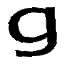

In [79]:
print(len(train_dataset))
print("Shapes:")
for images, char_codes, labels in train_loader:
    print(f"    {images.shape     = }") # should be (batch_size, 1, 20, 20)
    print(f"    {char_codes.shape = }") # should be (batch_size,)
    print(f"    {labels.shape     = }") # should be (batch_size,)

    print(
        "\nExample:",
        chr(int(char_codes[0])),
        train_dataset.label_reverse_mapping[int(labels[0])],
    )
    display(transform_for_printing(images[0]))

    break


---

# **3. CNN Model - Creation and training**

## Model description

The model's summary is as follows:
Since there are two inputs, namely Image and Character code, we pass them
through separate sequences of layers, and then concat their outputs. This
concatenated output is then fed into regular NN layers.

Note:
- All **Conv2d** layers have a 3x3 kernel with padding 1. Its input and output denotes number of images/. TODO:
- All **MaxPool2d** layers have a 2x2 kernel with stride 2, effectively halving the resolution. Its input and output denotes resolution of the image.

*Sequence 1:*
| #    | Input   | Layer           | Output  |
| ---: | ---     | ---             | ---     |
|      |         | one 20×20 Image |         |
| 1.   | $1$     | Conv2d          | $16$    |
| 2.   | $20×20$ | MaxPool2d       | $10×10$ |
| 3.   | $16$    | Conv2d          | $32$    |
| 4.   | $10×10$ | MaxPool2d       | $5×5$   |
| 5.   | $32$    | Conv2d          | $64$<b style="color: red">*</b>  |
| 6.   | $5×5$   | MaxPool2d       | $2×2$<b style="color: red">*</b> |
|      |         | $64×2×2$        |         |

*Sequence 2:*
| #    | Input    | Layer           | Output          |
| ---: | ---      | ---             | ---             |
|      |          | Character code  |                 |
| 1.   | 65533+10 | Embedding       | `char_code_dim` |
|      |          | `char_code_dim` |                 |

Concat of *Sequence 1* and *Sequence 2* gives
$64\times 2\times 2 +$ `char_code_dim` values.

This is then passed on to the following NN layers:
| #    | Input   | Layer       | Output  |
| ---: | ---     | ---         | ---     |
| 1.   | $64\times 2\times 2 +$ `char_code_dim` | Linear | $128$ |
| 2.   | $128$ | Linear | `num_fonts` |


In [9]:
class FontIdentificationModel(nn.Module):
    def __init__(self, num_fonts, largest_char_code: int, char_code_dim=64):
        super(FontIdentificationModel, self).__init__()

        # CNN https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148
        # For Conv2d layers, we neither use stride>1 nor dilation, since the
        # images are already low in resolution.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.3)

        # The sequence of layers below are as described in "Sequence 1" above.
        self.layer1_conv = nn.Conv2d(1, 128, kernel_size=15, padding=7) # the 1 input stands for 1-channel image i.e. grayscale.
        self.layer1_conv_bn = nn.BatchNorm2d(128)
        self.layer2_conv = nn.Conv2d(128, 64, kernel_size=15, padding=7)
        self.layer2_conv_bn = nn.BatchNorm2d(64)
        self.layer3_conv = nn.Conv2d(64, 32, kernel_size=7, padding=3)
        self.layer3_conv_bn = nn.BatchNorm2d(32)
        self.layer4_conv = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.layer4_conv_bn = nn.BatchNorm2d(32)

        # The sequence of (one) layer below is as described in "Sequence 2" above.
        self.char_code_embedding = nn.Embedding(largest_char_code+10, char_code_dim)

        # The above two sequences are concatenated (in `forward()`) and then fed
        # to regular NN layers.
        self.layer5_fc = nn.Linear(32 * 8 * 8 + char_code_dim, 256)
        self.layer6_fc = nn.Linear(256, num_fonts)

    def forward(self, image, char_code):
        # Image feature extraction
        x = self.dropout(self.layer1_conv_bn(self.pool(F.relu(self.layer1_conv(image)))))
        x = self.dropout(self.layer2_conv_bn(self.pool(F.relu(self.layer2_conv(x)))))
        x = self.dropout(self.layer3_conv_bn(self.pool(F.relu(self.layer3_conv(x)))))
        x =              self.layer4_conv_bn(          F.relu(self.layer4_conv(x)))
        x = torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)  # Flatten in-place(?)

        # Character code embedding
        char_features = self.char_code_embedding(char_code)

        # Concatenate Sequence 1 and Sequence 2 as described above.
        combined = torch.cat((x, char_features), dim=1)

        # Fully connected layers
        x = F.relu(self.layer5_fc(combined))
        x = self.layer6_fc(x)
        # x = self.layer6_softmax(x)
        return x


## Model training

In [35]:
# Benefit of CPU-only: errors will show up correctly, hence useful for debugging.
FORCE_USE_CPU = ipywidgets.Checkbox(value=False, description="Use CPU forcefully")
FORCE_USE_CPU

Checkbox(value=False, description='Use CPU forcefully')

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() and not FORCE_USE_CPU.value else 'cpu')
model = FontIdentificationModel(num_fonts=len(train_dataset.label_mapping), largest_char_code=max(train_dataset.codes), char_code_dim=128).to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
model.apply(weights_init)

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network
criterion = nn.CrossEntropyLoss()  # Suitable for classification
# optimizer = optim.Adam(model.parameters(), lr=0.03)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

last_print_time = perf_counter()
for epoch in range(30): # Epoch count
    model.train()
    running_loss = 0.0
    epoch_start_time = perf_counter()
    print(f"Starting Epoch {epoch}, number of batches: {len(train_loader)}... (batch size: {len(char_codes)})")
    for i, (images, char_codes, labels) in enumerate(train_loader):
        images, char_codes, labels = images.to(device), char_codes.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, char_codes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 108 == 0:
            print(f"    Epoch {epoch}, batch {i+1:5d} done. Loss: {running_loss / (i+1)} ({(now := perf_counter()) - last_print_time:.2f}s since last print)")
            last_print_time = now

            # https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended
            torch.save(model.state_dict(), f"{PATH_MODELS}/e{epoch:02d} b{i+1:05d} - l {running_loss / (i+1):.5f}.pth")

    scheduler.step()
    print(f"    Epoch {epoch}, batch {i+1:5d} done. Loss: {running_loss / len(train_loader)} ({perf_counter() - epoch_start_time:.2f} sec for epoch)")

    # https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended
    torch.save(model.state_dict(), f"{PATH_MODELS}/e{epoch:02d} b{len(train_loader):05d} - l {running_loss / len(train_loader):.5f} (complete).pth")


Starting Epoch 0, number of batches: 324... (batch size: 128)
    Epoch 0, batch     1 done. Loss: 6.098939418792725 (0.64s since last print)
    Epoch 0, batch   109 done. Loss: 4.879773756779662 (23.30s since last print)
    Epoch 0, batch   217 done. Loss: 4.548040508674586 (27.53s since last print)
    Epoch 0, batch   324 done. Loss: 4.318683077523738 (74.92 sec for epoch)
Starting Epoch 1, number of batches: 324... (batch size: 72)
    Epoch 1, batch     1 done. Loss: 3.5947751998901367 (23.66s since last print)
    Epoch 1, batch   109 done. Loss: 3.5428197121401444 (22.91s since last print)
    Epoch 1, batch   217 done. Loss: 3.4399325550975886 (22.50s since last print)
    Epoch 1, batch   324 done. Loss: 3.3651400083377037 (67.60 sec for epoch)
Starting Epoch 2, number of batches: 324... (batch size: 72)
    Epoch 2, batch     1 done. Loss: 2.921557664871216 (22.21s since last print)
    Epoch 2, batch   109 done. Loss: 2.970694235705454 (22.82s since last print)
    Epoch 2

## Model evaluation

In [37]:
# test_dataset = FontDataset(characters, transform_image=transform_image)  # Use the same transform as for training
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_dataset = train_dataset
test_loader = train_loader

print("Testing against same dataset:")
for model_eval_path in glob("D:\\OneDrive - BITS PILANI\\Year 3 Sem 1\\FDS Project\\Models\\*complete*.pth")[::-1]:
    t_start = perf_counter()
    model_eval = FontIdentificationModel(num_fonts=len(test_dataset.label_mapping), largest_char_code=max(test_dataset.codes), char_code_dim=128).to(device)
    model_eval.load_state_dict(torch.load(model_eval_path, weights_only=True))
    model_eval.eval() # Set the model to evaluation mode
    correct = 0
    total = 0

    # Reverse the label mapping to decode predictions
    index_to_label = {i: label for label, i in test_dataset.label_mapping.items()}

    with torch.no_grad():
        for i, (images, char_codes, labels) in enumerate(test_loader):
            images, char_codes, labels = images.to(device), char_codes.to(device), labels.to(device)

            # Forward pass
            outputs = model_eval(images, char_codes)

            # Get predictions
            _, predicted = torch.max(outputs, dim=1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # if i % 50 == 0:
            #     print(f"    Tested {i+1} batches, accuracy so far: {100*correct / total:.2f}%")

    # Compute accuracy
    accuracy = correct / total
    print(f"{basename(model_eval_path)} - Total accuracy: {accuracy * 100:.2f}% ({perf_counter() - t_start:.2f} sec)")


Testing against same dataset:
e29 b00324 - l 0.94693 (complete).pth - Total accuracy: 78.02% (44.88 sec)
e28 b00324 - l 0.96182 (complete).pth - Total accuracy: 77.20% (43.93 sec)
e27 b00324 - l 0.98651 (complete).pth - Total accuracy: 77.10% (43.74 sec)
e26 b00324 - l 0.99968 (complete).pth - Total accuracy: 76.51% (43.11 sec)
e25 b00324 - l 1.00856 (complete).pth - Total accuracy: 75.62% (40.00 sec)


KeyboardInterrupt: 

## Model testing with input

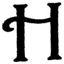

[(80, 62.40455508232117, 'Harrington'),
 (105, 14.941811561584473, 'Maiandra GD'),
 (53, 7.448449730873108, 'Eras Medium ITC'),
 (24, 4.391280189156532, 'Candara'),
 (44, 2.47245691716671, 'Droid Sans Mono Slashed'),
 (6, 1.3729977421462536, 'Baskerville Old Face'),
 (55, 1.2391218915581703, 'Footlight MT Light'),
 (57, 0.7032192312180996, 'Franklin Gothic Book'),
 (149, 0.6138642784208059, 'Sitka'),
 (41, 0.5812343675643206, 'DejaVu Sans')]

Font name,Sample text
Harrington,
Maiandra GD,
Eras Medium ITC,
Candara,
Droid Sans Mono Slashed,
Baskerville Old Face,
Footlight MT Light,
Franklin Gothic Book,
Sitka,
DejaVu Sans,

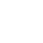
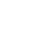
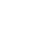
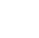
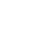
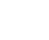
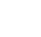
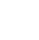
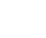
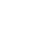

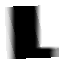

'L'

'Impact'

[(82, 38.20342719554901, 'Impact'),
 (147, 34.39012169837952, 'Showcard Gothic'),
 (72, 16.975513100624084, 'Gill Sans MT Ext Condensed Bold'),
 (159, 6.331228464841843, 'Tw Cen MT Condensed Extra Bold'),
 (78, 3.507467359304428, 'Haettenschweiler'),
 (59, 0.3436506958678365, 'Franklin Gothic Demi Cond'),
 (60, 0.08230370003730059, 'Franklin Gothic Heavy'),
 (74, 0.04466941754799336, 'Gill Sans Ultra Bold Condensed'),
 (158, 0.03551744157448411, 'Tw Cen MT Condensed'),
 (73, 0.02227490476798266, 'Gill Sans Ultra Bold')]

Font name,Sample text
Impact,
Showcard Gothic,
Gill Sans MT Ext Condensed Bold,
Tw Cen MT Condensed Extra Bold,
Haettenschweiler,
Franklin Gothic Demi Cond,
Franklin Gothic Heavy,
Gill Sans Ultra Bold Condensed,
Tw Cen MT Condensed,
Gill Sans Ultra Bold,

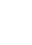
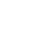
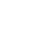

In [27]:
TEST_PATH_IMAGE = "H.jpg"
TEST_CHARCODE = ord("H")
device = torch.device('cuda')

from IPython.display import HTML
test_dataset = train_dataset
test_loader = train_loader

# Prepare image
img = Image.open(TEST_PATH_IMAGE).convert("L")
# for value in Image.Resampling: display(value, img.resize((128,128), resample=value))
# img = img.resize((64,64))
img = DatasetCustom.CreateDataset.prepare_image(img, 64)
display(img)
img_transformed = transform_image_no_affine(torch.tensor(np.array(img))).unsqueeze(dim=0)
# display(transform_for_printing(img_transformed.squeeze(dim=0)))

# Prepare char code
char_code = torch.tensor([TEST_CHARCODE])

model_eval_path = "D:\\OneDrive - BITS PILANI\\Year 3 Sem 1\\FDS Project\\Models\\e29 b00324 - l 0.94693 (complete).pth"
model_eval = FontIdentificationModel(num_fonts=len(test_dataset.label_mapping), largest_char_code=max(test_dataset.codes), char_code_dim=128).to(device)
model_eval.load_state_dict(torch.load(model_eval_path, weights_only=True))
model_eval.eval() # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_eval(img_transformed.to(device), char_code.to(device)).squeeze(dim=0)
    outputs = nn.Softmax(dim=0)(outputs)

o = [(i, score*100, test_dataset.label_reverse_mapping[i]) for i, score in enumerate(outputs.tolist())]

o.sort(key=lambda entry: entry[1], reverse=True)
display(o[:10])
display(HTML(DatasetCustom.CreateDataset.preview_html_image([x[2] for x in o[:10]], chr(TEST_CHARCODE), 60)))

# ---------------------------------------------------------------------------- #

for images, char_codes, labels in test_loader:
    display(transform_for_printing(images[0]), chr(int(char_codes[0])), test_dataset.label_reverse_mapping[int(labels[0])])

    image = images[0].unsqueeze(0)
    char_code = char_codes[0].unsqueeze(0)

    model_eval.eval()
    with torch.no_grad():
        outputs = model_eval(image.to(device), char_code.to(device)).squeeze(dim=0)
        outputs = nn.Softmax(dim=0)(outputs)
    o = [(i, score*100, test_dataset.label_reverse_mapping[i]) for i, score in enumerate(outputs.tolist())]

    o.sort(key=lambda entry: entry[1], reverse=True)
    display(o[:10])
    display(HTML(DatasetCustom.CreateDataset.preview_html_image([x[2] for x in o[:10]], chr(char_code), 60)))

    break



---

# **4. Confusion matrix**

To generate a confusion matrix for a given character.

In [10]:
MODEL_PATH = "Models/e29 b00324 - l 0.94693 (complete).pth"

device = torch.device('cuda')
model_conf = FontIdentificationModel(num_fonts=len(train_dataset.label_mapping), largest_char_code=max(train_dataset.codes), char_code_dim=128).to(device)
model_conf.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
model_conf.eval() # Set the model to evaluation mode

def predict(img: Image.Image, char_code: int) -> list[float]:
    img = DatasetCustom.CreateDataset.prepare_image(img, 64)
    img_transformed = transform_image_no_affine(torch.tensor(np.array(img))).unsqueeze(dim=0)

    with torch.no_grad():
        outputs = model_conf(img_transformed.to(device), torch.tensor([char_code], device=device)).squeeze(dim=0)
        outputs = nn.Softmax(dim=0)(outputs)

    # o = [(i, score, test_dataset.label_reverse_mapping[i]) for i, score in enumerate(outputs.tolist())]
    # o.sort(key=lambda entry: entry[1], reverse=True)
    # return o
    return outputs.tolist()


In [64]:
CHARACTER = "P"

num_fonts = len(train_dataset.label_mapping)
indices = np.equal(train_dataset.codes, ord(CHARACTER)).nonzero()[0]

outcome_actual    = np.full((len(indices),), -1, dtype=np.int32)
outcome_predicted = np.full((len(indices),), -1, dtype=np.int32)

for entry_i, index in enumerate(indices):
    image, char_code, label_actual = train_dataset[index]
    image = transform_for_printing(image)
    predictions = predict(image, char_code)
    predictions_sorted = sorted(enumerate(predictions), key=lambda entry: entry[1], reverse=True)
    label_predicted = predictions_sorted[0][0]

    outcome_predicted[entry_i] = label_predicted
    outcome_actual[entry_i] = label_actual


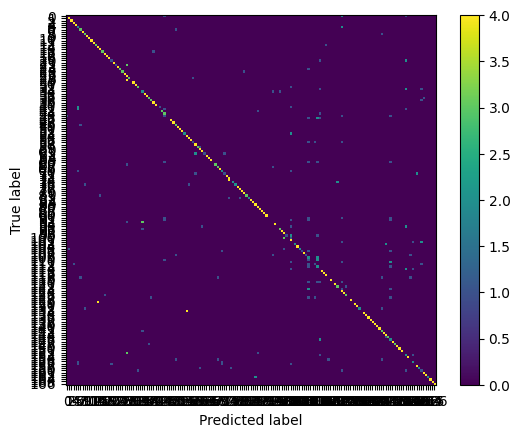

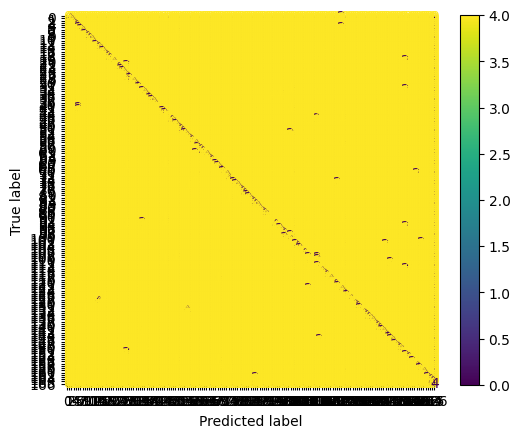

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cdm = ConfusionMatrixDisplay.from_predictions(
    outcome_actual,
    outcome_predicted,
    include_values=False,
)

# import pandas as pd
# pd.DataFrame(cm).to_csv("conf matrix.csv", header=False, index=False)